In [2]:
import json
import os

import torch
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from torch import nn
from torch.utils.data import DataLoader

from data_utils import save_model, get_dataset_path, visualize_batch
from data_utils.BrainDataset import BrainDataset
from data_utils.BrainSampler import BrainSampler
from gan import GAN, Discriminator

In [3]:
training_params = {
    "batch_size" : 256,
    "batch_gpu" : 256,
    "train_time" : int(1*10e2),
    "tile_size" : 64,
    "training_brains" : [(1818, 759, "left"), (1818,820, "right"), (1818, 830, "right")],
    "map_type" : "fom",
    "resolution": "00",
    "lr_disc" : 5e-5,
    "lr_gan" : 5e-5,
    "wd_disc" : 0,
    "wd_gan" : 0,
    "latent_dim" : 32,
    "n_critic": 1,
}
assert training_params["batch_size"] % training_params["batch_gpu"] == 0
torch.random.manual_seed(0)
data = BrainDataset(training_params["training_brains"], training_params["map_type"], training_params["resolution"])
sampler = BrainSampler(data, tile_size=training_params["tile_size"], map_type=training_params["map_type"])
loader = DataLoader(data, sampler=sampler, batch_size=training_params["batch_size"])

model = GAN(training_params["tile_size"], 3 if training_params["map_type"] == "fom" else 1, training_params["latent_dim"])
discriminator = Discriminator(training_params["tile_size"], 3 if training_params["map_type"] == "fom" else 1)
optimizer_gan = torch.optim.Adam(model.parameters(), lr=training_params["lr_gan"], weight_decay=training_params["wd_gan"])
optimizer_disc = torch.optim.Adam(discriminator.parameters(), lr=training_params["lr_disc"], weight_decay=training_params["wd_disc"])
device = torch.device("cuda")

In [3]:
def training_loop():
    losses_disc = []
    losses_gan = []
    model.train()
    model.to(device)
    discriminator.train()
    discriminator.to(device)
    total_batch_count = training_params["train_time"] // training_params["batch_size"]
    data_iter = iter(loader)
    pbar = tqdm(range(total_batch_count))
    eps = 1e-6
    for _ in pbar:
        batch_loss_gan = 0
        # Optimize Discriminator
        for i in range(training_params["n_critic"]):
            batch_loss_disc = 0
            optimizer_disc.zero_grad()
            for _ in range(training_params["batch_size"] // training_params["batch_gpu"]):
                x = next(data_iter)[0].to(device)
                z = torch.randn(training_params["batch_gpu"], training_params["latent_dim"], device=device)
                batch_loss_disc -= (torch.log(discriminator(x) + eps).sum() + torch.log(1 - discriminator(model(z)) + eps).sum()) / training_params["batch_gpu"]
            if batch_loss_disc is not torch.nan:
                batch_loss_disc.backward()
                torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 1)
                optimizer_disc.step()


        # Optimize GAN
        optimizer_gan.zero_grad()
        for _ in range(training_params["batch_size"] // training_params["batch_gpu"]):
            z = torch.randn(training_params["batch_gpu"], training_params["latent_dim"], device=device)
            batch_loss_gan -= torch.log(discriminator(model(z)) + eps).sum() / training_params["batch_gpu"]
        if batch_loss_gan is not torch.nan:
            batch_loss_gan.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer_gan.step()

        pbar.set_description(f"Discriminator loss: {batch_loss_disc:.4f} GAN loss: {batch_loss_gan:.4f}")
        losses_disc.append(batch_loss_disc.item())
        losses_gan.append(batch_loss_gan.item())
    save_model(model,discriminator, training_params)
    return losses_disc, losses_gan

  0%|          | 0/3 [00:00<?, ?it/s]

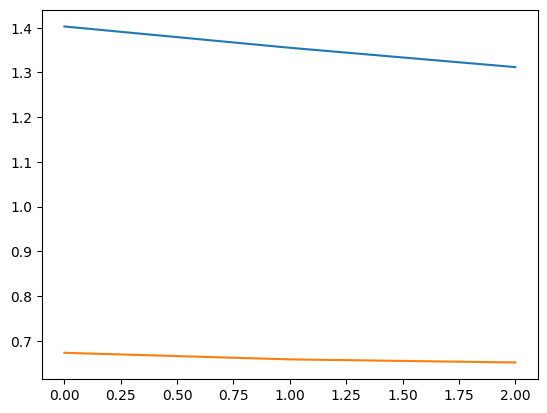

In [4]:
losses_disc, losses_gan = training_loop()
plt.plot(losses_disc)
plt.plot(losses_gan)


In [4]:
model_name = "8006146278150"
model_dict = torch.load(os.path.join(get_dataset_path(), f"../models", f"{model_name}/model.pt"), weights_only=True)
options = json.load(open(os.path.join(get_dataset_path(), "../models", f"{model_name}/options.json"), "r"))
model = GAN(options["tile_size"], 3, options["latent_dim"])
model.load_state_dict(model_dict)
model = model.eval()
model = model.to(device)


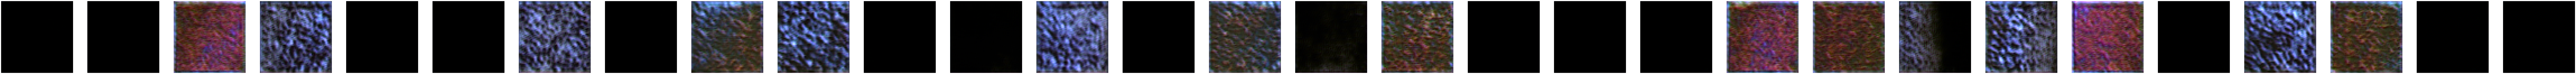

In [5]:
torch.random.manual_seed(0)
samples = model.sample(30)
visualize_batch(samples, "fom")
